# Sentiment Analysis with LSTM and Additional Features

### Import Libraries, defining funtions and constants

In [134]:
# Paths to save the pickle files
train_features_path = "train_features.pkl"
test_features_path = "test_features.pkl"

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.datasets.reuters import get_word_index
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, GlobalMaxPooling1D, Conv1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [136]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import contractions
import spacy.cli

In [137]:
import pickle
import os

In [138]:
# Function to save data to a pickle file
def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Function to load data from a pickle file
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [139]:
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [140]:
nltk.download('punkt')  # Download the punkt tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [141]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [142]:
nlp = spacy.load("en_core_web_sm")

In [143]:

# Abbreviation and apostro  phe dictionaries
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

# Copied from https://www.kaggle.com/code/gauravchhabra/nlp-twitter-sentiment-analysis-project

In [144]:
# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Initialize VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Function to replace abbreviations and apostrophes
def expand_text(text, short_dict):
    text = contractions.fix(text)  # Expand contractions using 'contractions' library
    text = text.lower().split()
    expanded_words = []
    for word in text:
        if word in short_dict:
            expanded_words.append(short_dict[word])
        else:
            expanded_words.append(word)
    return " ".join(expanded_words)

# Function to extract additional features from the text
def extract_additional_features(texts):
    features = []

    for text in texts:
        # Expand short words and contractions
        text = expand_text(text, short_word_dict)

        # Tokenize text
        tokens = word_tokenize(text)

        # Feature 1: Length of text (in words)
        text_length = len(tokens)

        # Feature 2: Stopword ratio
        stopword_count = sum([1 for word in tokens if word in stop_words])
        stopword_ratio = stopword_count / text_length if text_length > 0 else 0

        # Feature 3: Sentiment score (using VADER sentiment analyzer)
        sentiment_score = vader_analyzer.polarity_scores(text)['compound']

        # Feature 4: Unique word ratio
        unique_word_ratio = len(set(tokens)) / text_length if text_length > 0 else 0

        # Feature 5: Named entity recognition (NER) count using spaCy
        doc = nlp(text)
        named_entities = [ent.label_ for ent in doc.ents]
        ner_count = len(named_entities)

        # Combine features into a feature vector
        features.append([
            text_length,
            stopword_ratio,
            sentiment_score,
            unique_word_ratio,
            ner_count
        ])

    return features

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load an Preprocess Data

In [145]:
vocab_size = 50000 # Load IMBD dataset with 50000 words most frequente
max_len = 200 # max length of the review

In [146]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [147]:
# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train, maxlen=max_len)
X_test_padded = pad_sequences(X_test, maxlen=max_len)

In [148]:
# Load the word index for reverse mapping
word_index = get_word_index()

# Reverse the word index for easier interpretation
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Helper function to map word indices back to actual words
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i - 3, "?") for i in encoded_review])

In [149]:
# Check if the pickle files exist, if not, generate and save them
if os.path.exists(train_features_path) and os.path.exists(test_features_path):
    # Load the features from the pickle files
    print("Loading features from pickle files...")
    train_features = load_from_pickle(train_features_path)
    test_features = load_from_pickle(test_features_path)
else:
    # Generate the features and save them
    print("Generating features and saving to pickle files...")
    train_features = extract_additional_features([decode_review(x) for x in X_train])
    test_features = extract_additional_features([decode_review(x) for x in X_test])

    # Save the generated features to pickle files
    save_to_pickle(train_features, train_features_path)
    save_to_pickle(test_features, test_features_path)

Loading features from pickle files...


In [150]:
# Normalize additional features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [151]:
# Split the data
X_train_seq, X_val_seq, X_train_feat, X_val_feat, y_train, y_val = train_test_split(
    X_train_padded, train_features_scaled, y_train, test_size=0.2, random_state=42
)

## Model

In [152]:
# Define inputs
sequence_input = Input(shape=(max_len,), dtype='int32', name='sequence_input')
feature_input = Input(shape=(train_features_scaled.shape[1],), name='feature_input')

In [153]:
# Sequence branch with LSTM
x = Embedding(vocab_size, 256, input_length=max_len)(sequence_input)
x = Conv1D(128, 5, activation='relu')(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)

c:\Users\chama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [154]:
# Feature branch
y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(feature_input)
y = Dropout(0.3)(y)
y = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.3)(y)

In [155]:
# Combine branches
combined = concatenate([x, y])

In [156]:
# Dense layers after combination
z = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
z = Dropout(0.4)(z)
z = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(z)
z = Dropout(0.4)(z)
output = Dense(1, activation='sigmoid')(z)

In [157]:
model = Model(inputs=[sequence_input, feature_input], outputs=output)

In [158]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [159]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

In [160]:
# Train the model
history = model.fit(
    [X_train_seq, X_train_feat], y_train,
    validation_data=([X_val_seq, X_val_feat], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 422ms/step - accuracy: 0.6439 - loss: 1.4059 - val_accuracy: 0.8706 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 420ms/step - accuracy: 0.9199 - loss: 0.2535 - val_accuracy: 0.8808 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 418ms/step - accuracy: 0.9692 - loss: 0.1309 - val_accuracy: 0.8722 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.9830 - loss: 0.0836 - val_accuracy: 0.8732 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9903 - loss: 0.0543
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 418ms/step - accuracy: 0.9903 - loss: 0.0543 - val_accuracy: 0.8628 - val_loss: 0.5590 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.9970 - 

In [161]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_test_padded, test_features_scaled], y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.8744


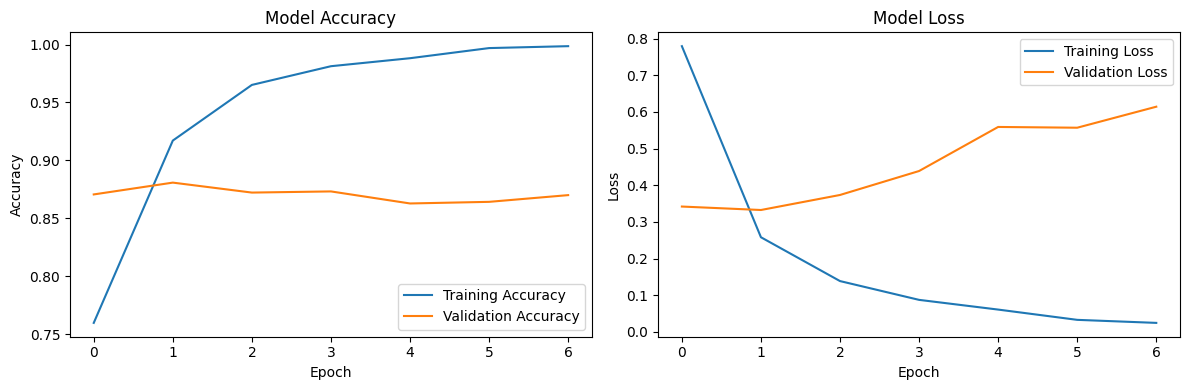

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 200, 256)  │ 12,800,000 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 196, 128)  │    163,968 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 196, 256)  │    263,168 │ conv1d_2[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 196, 256)  │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │        384 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 196, 128)  │    164,352 │ dropout_27[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_7[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 32)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160)       │          0 │ dropout_28[0][0], │
│ (Concatenate)       │                   │            │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     20,608 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128)       │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │      8,256 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 40,268,645 (153.61 MB)

 Trainable params: 13,422,881 (51.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,845,764 (102.41 MB)

In [162]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print model summary
model.summary()